In [408]:
import os, re
from os.path import isdir, join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Load documents and scrutinize unwanted punctuations
**Load documents**

In [347]:
raw_path = u'./corpus/raw-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(raw_path) if isdir(join(raw_path, fn))] # list only folders
print 'Showing one sample document label'
print 'Unicode codepoints representation:', repr(doc_labels[0]), '::', type(doc_labels[0])
print 'The actual glyph (appearance):', doc_labels[0]

Showing one sample document label
Unicode codepoints representation: u'\u0e1b\u0e23\u0e30\u0e21\u0e07' :: <type 'unicode'>
The actual glyph (appearance): ประมง


**Show all document labels**

In [291]:
doc_labels_idx = {} # maps label name to its corresponding index
print 'Total labels:', len(doc_labels)
for i, label in enumerate(doc_labels):
    doc_labels_idx[label] = i
    print "%d: %s" % (i, label)

Total labels: 15
0: ประมง
1: มนุษยศาสตร์
2: วนศาสตร์
3: วิทยาศาสตร์
4: วิทยาศาสตร์การกีฬา
5: วิศวกรรมศาสตร์ กำแพงแสน
6: ศึกษาศาสตร์
7: สังคมศาสตร์
8: สัตวแพทยศาสตร์
9: สิ่งแวดล้อม
10: อุตสาหกรรมเกษตร
11: เกษตร
12: เกษตร กำแพงแสน
13: เศรษฐศาสตร์
14: โครงการสหวิทยาการระดับบัณฑิตศึกษา


**Open documents from each folder**

In [478]:
label_freqs, content_lengths = [], []
dataset_contents, dataset_labels = [], [] # will be used later
for i, label in enumerate(doc_labels):
    curr_dir = join(raw_path, label)
    fns = os.listdir(curr_dir)
#     print len(fns), label
    label_freqs.append(len(fns))
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'tis-620')
            content_lengths.append(len(content))
            dataset_contents.append(content)
            dataset_labels.append(i)

**Show number of files in each folder**

<IPython.core.display.Javascript object>


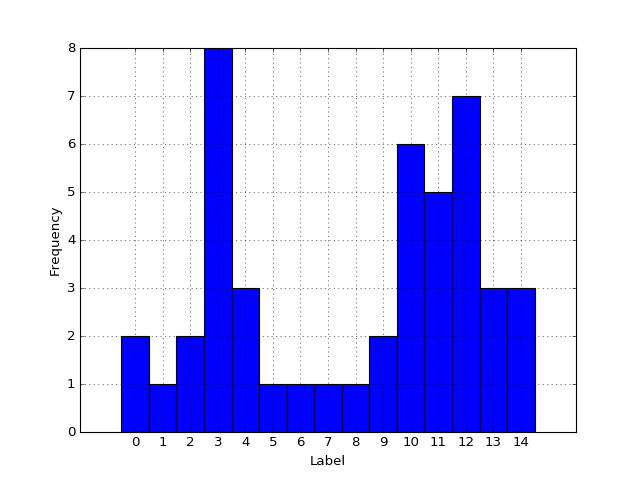

In [474]:
plt.figure()
plt.bar(np.arange(len(doc_labels))-0.5, label_freqs, 1)
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid()
plt.show()

**Show dataset statistics**

In [480]:
print 'Total documents:', len(dataset_contents)
print 'Label Frequencies:', label_freqs
print 'Label Frequencies Mean:', np.mean(label_freqs)
print 'Content Lengths Mean:', np.mean(content_lengths)

Total documents: 46
Label Frequencies: [2, 1, 2, 8, 3, 1, 1, 1, 1, 2, 6, 5, 7, 3, 3]
Label Frequencies Mean: 3.06666666667
Content Lengths Mean: 585066.652174


**Show histogram of content lengths**

<IPython.core.display.Javascript object>


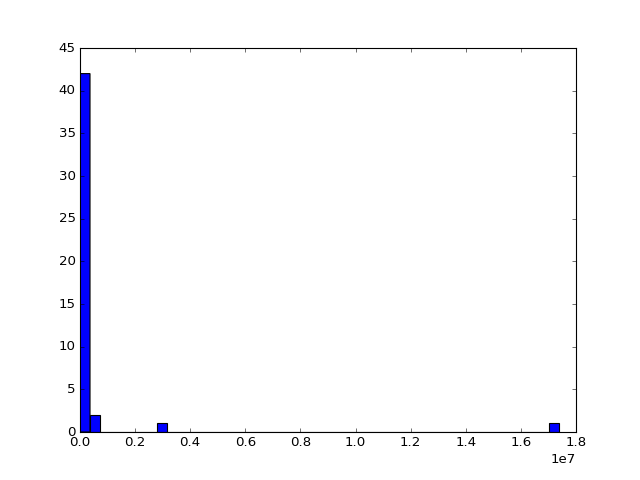

In [488]:
plt.figure()
plt.hist(content_lengths, bins=50)
plt.show()

## Scrutinize unwanted punctuations
**Define scrutinize() function**

In [468]:
punctuations = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \r\n')
scrutinize = lambda s: ''.join(c for c in s if c not in punctuations) # use 

**Sample Original Content**

In [460]:
sample = dataset_contents[1][:2**8]
print sample
sample

I49620305
Ipage 
Iวิทยานิพนธ์
Pการศึกษาคุณลักษณะ complementary dnas (cdnas) และการแสดงออกของยีน anti-lipopolysaccharide factors ในกุ้งก้ามกราม (macrobrachium rosenbergii, de man)
Pmolecular characterization of complementary dnas (cdnas) and expression of a


u'I49620305\nIpage \nI\u0e27\u0e34\u0e17\u0e22\u0e32\u0e19\u0e34\u0e1e\u0e19\u0e18\u0e4c\nP\u0e01\u0e32\u0e23\u0e28\u0e36\u0e01\u0e29\u0e32\u0e04\u0e38\u0e13\u0e25\u0e31\u0e01\u0e29\u0e13\u0e30 complementary dnas (cdnas) \u0e41\u0e25\u0e30\u0e01\u0e32\u0e23\u0e41\u0e2a\u0e14\u0e07\u0e2d\u0e2d\u0e01\u0e02\u0e2d\u0e07\u0e22\u0e35\u0e19 anti-lipopolysaccharide factors \u0e43\u0e19\u0e01\u0e38\u0e49\u0e07\u0e01\u0e49\u0e32\u0e21\u0e01\u0e23\u0e32\u0e21 (macrobrachium rosenbergii, de man)\nPmolecular characterization of complementary dnas (cdnas) and expression of a'

**Sample Content Scrutinized**

In [469]:
scrutinized = scrutinize(sample)
print scrutinized
scrutinized

I49620305IpageIวิทยานิพนธ์Pการศึกษาคุณลักษณะcomplementarydnascdnasและการแสดงออกของยีนantilipopolysaccharidefactorsในกุ้งก้ามกรามmacrobrachiumrosenbergiidemanPmolecularcharacterizationofcomplementarydnascdnasandexpressionofa


u'I49620305IpageI\u0e27\u0e34\u0e17\u0e22\u0e32\u0e19\u0e34\u0e1e\u0e19\u0e18\u0e4cP\u0e01\u0e32\u0e23\u0e28\u0e36\u0e01\u0e29\u0e32\u0e04\u0e38\u0e13\u0e25\u0e31\u0e01\u0e29\u0e13\u0e30complementarydnascdnas\u0e41\u0e25\u0e30\u0e01\u0e32\u0e23\u0e41\u0e2a\u0e14\u0e07\u0e2d\u0e2d\u0e01\u0e02\u0e2d\u0e07\u0e22\u0e35\u0e19antilipopolysaccharidefactors\u0e43\u0e19\u0e01\u0e38\u0e49\u0e07\u0e01\u0e49\u0e32\u0e21\u0e01\u0e23\u0e32\u0e21macrobrachiumrosenbergiidemanPmolecularcharacterizationofcomplementarydnascdnasandexpressionofa'